# Phase 5 – Natural-Language Query Demo  
### YOLOv8m • OWL-ViT • GroundingDINO  
---

This notebook demonstrates **interactive, natural-language object detection** using all three models in our pipeline:

### **1. YOLOv8 (Closed-Set)**  
Detects only the objects it was explicitly trained on — in our case, **1 class: obstacle** from MaSTr1325.

### **2. OWL-ViT (Open-Vocabulary – Google Research)**  
Detects arbitrary objects using **text prompts** without any fine-tuning.

### **3. Grounding DINO (IDEA Research)**  
Detects arbitrary objects via **phrase grounding**, producing richer region-level understanding.

---

### 🌊 Demo Capability
Enter prompts like:

- “boat”
- “orange buoy”
- “small debris”
- “person on kayak”
- “floating plastic”
- “dock structure”
- “big white ship”

All models run on the chosen image and produce side-by-side predictions.

---

### 🎯 Purpose of this Notebook
This notebook exists to create **presentation-ready visualizations**, showing:

- Contrast between **closed-set** and **open-vocabulary** detection  
- How **language changes the model’s behavior**  
- How GroundingDINO understands **phrases**, not just words  
- Why open-vocabulary methods outperform YOLO in **unseen obstacle detection**

This is the *showpiece* notebook of your project.


### Imports & Environment Setup

In [ ]:
import torch
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# Base folder (same as previous notebooks)
BASE_DIR = Path.cwd().parents[0]
DATA_DIR = BASE_DIR / "data"
VAL_IMAGES = DATA_DIR / "images" / "val"

# Output directory
DEMO_RESULTS = BASE_DIR / "demo_outputs"
DEMO_RESULTS.mkdir(parents=True, exist_ok=True)
print(BASE_DIR)


Using device: cuda


### Load YOLOv8 Model

In [2]:
# YOLOv8
from ultralytics import YOLO
YOLO_WEIGHTS = BASE_DIR/"notebooks/runs/detect/yolov8m_stable2/weights/best.pt"
model_yolo = YOLO(str(YOLO_WEIGHTS))

# OWL-ViT
from transformers import OwlViTProcessor, OwlViTForObjectDetection
OWL_MODEL = "google/owlvit-base-patch32"
processor_owl = OwlViTProcessor.from_pretrained(OWL_MODEL)
model_owl = OwlViTForObjectDetection.from_pretrained(
    OWL_MODEL, torch_dtype=torch.float32
).to(device)

# Grounding DINO
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
DINO_MODEL = "IDEA-Research/grounding-dino-tiny"
processor_dino = AutoProcessor.from_pretrained(DINO_MODEL)
model_dino = AutoModelForZeroShotObjectDetection.from_pretrained(
    DINO_MODEL, dtype=torch.float32
).to(device)

print("✔ All models loaded")


d:\Sem3\CS581B_Robot_Perception\Project\Implementation\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
`torch_dtype` is deprecated! Use `dtype` instead!


✔ All models loaded


### Unified Drawing Function

In [3]:
def draw_boxes(ax, image, boxes, scores, labels, color):
    ax.imshow(image)
    for (box, score, label) in zip(boxes, scores, labels):
        x1, y1, x2, y2 = box
        ax.add_patch(plt.Rectangle(
            (x1, y1), x2 - x1, y2 - y1,
            fill=False, edgecolor=color, linewidth=2
        ))
        ax.text(x1, y1, f"{label} {score:.2f}",
                color=color, fontsize=9,
                bbox=dict(facecolor="black", alpha=0.4))
    ax.axis("off")

### Inference Functions

#### YOLOv8m

In [4]:
def run_yolo(img_path):
    res = model_yolo(str(img_path))[0]
    boxes = res.boxes.xyxy.cpu().numpy()
    scores = res.boxes.conf.cpu().numpy()
    labels = ["obstacle"] * len(scores)   # closed-set
    return boxes, scores, labels

#### OWL-ViT

In [5]:
def run_owl(img_path, queries, threshold=0.15):
    # Force list[str] format
    if isinstance(queries, str):
        queries = [queries]
    else:
        # Flatten nested lists: [["debris"]] → ["debris"]
        queries = [q for sub in queries for q in (sub if isinstance(sub, list) else [sub])]
        queries = [str(q).strip() for q in queries if str(q).strip() != ""]

    # Ensure at least 1 text query
    if len(queries) == 0:
        queries = ["object"]

    # Debug print
    print("OWL Queries:", queries)

    # Load image
    image = Image.open(img_path).convert("RGB")

    # Preprocess
    inputs = processor_owl(text=queries, images=image, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model_owl(**inputs)

    # ---- CUSTOM POST-PROCESSOR (fixes HF bug) ----
    logits = outputs["logits"][0]           # shape: (num_queries, num_patches)
    boxes  = outputs["pred_boxes"][0]       # predicted boxes
    scores = logits.max(dim=-1).values      # one score per text query

    # Convert normalized xywh to xyxy
    img_w, img_h = image.size
    final_boxes = []
    final_scores = []
    final_labels = []

    for qi, score in enumerate(scores):
        if float(score) < threshold:
            continue

        bx = boxes[qi].cpu().numpy()
        cx, cy, w, h = bx

        x1 = (cx - w/2) * img_w
        y1 = (cy - h/2) * img_h
        x2 = (cx + w/2) * img_w
        y2 = (cy + h/2) * img_h

        final_boxes.append([x1, y1, x2, y2])
        final_scores.append(float(score))
        final_labels.append(qi)

    return np.array(final_boxes), final_scores, final_labels


#### GroundingDINO

In [6]:
def run_dino(img_path, prompt):
    image = Image.open(img_path).convert("RGB")
    inputs = processor_dino(images=image, text=[prompt], return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model_dino(**inputs)

    results = processor_dino.post_process_grounded_object_detection(
        outputs, target_sizes=[image.size[::-1]]
    )[0]

    boxes = results["boxes"].cpu().numpy()
    scores = results["scores"].cpu().numpy()
    labels = results["labels"]  # already strings
    return boxes, scores, labels

### Directory Setup

In [7]:
from pathlib import Path

# Ensure consistent paths with notebook 02–04
BASE_DIR = Path.cwd().parents[0]
RESULTS_DIR = BASE_DIR / "notebooks" / "results"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print("📁 BASE_DIR =", BASE_DIR)
print("📁 RESULTS_DIR =", RESULTS_DIR)


📁 BASE_DIR = d:\Sem3\CS581B_Robot_Perception\Project\Implementation
📁 RESULTS_DIR = d:\Sem3\CS581B_Robot_Perception\Project\Implementation\notebooks\results


In [8]:
def clean_for_owlvit(prompt: str):
    """
    Convert a natural-language prompt into a clean OWL-ViT query.
    OWL-ViT works best with short nouns like: 'boat', 'buoy', 'debris'
    """
    p = prompt.lower().strip()

    # remove verbs
    for bad in ["detect", "find", "show", "identify", "locate"]:
        p = p.replace(bad, "")

    # remove articles
    for a in ["the", "a", "an"]:
        p = p.replace(" " + a + " ", " ")

    # cleanup punctuation
    p = p.replace(".", " ").replace(",", " ").replace("  ", " ").strip()

    # fallback if cleaned result is empty
    if len(p) == 0:
        return "object"

    return p


### Combined Language Query Demo & Saving Results

In [9]:
def run_language_demo(img_path, prompt):
    image = Image.open(img_path).convert("RGB")

    # YOLO (closed-set)
    y_boxes, y_scores, y_labels = run_yolo(img_path)

    # OWL-ViT expects simplified noun
    owl_query = clean_for_owlvit(prompt)
    o_boxes, o_scores, o_labels = run_owl(img_path, [owl_query])

    # DINO accepts full phrase
    d_boxes, d_scores, d_labels = run_dino(img_path, prompt)

    fig, axs = plt.subplots(1, 3, figsize=(22, 7))
    fig.suptitle(f"Language Query = \"{prompt}\"", fontsize=20)

    axs[0].set_title("YOLOv8 (Closed-Set)")
    draw_boxes(axs[0], image, y_boxes, y_scores, y_labels, "cyan")

    axs[1].set_title(f"OWL-ViT (Query = '{owl_query}')")
    draw_boxes(axs[1], image, o_boxes, o_scores, o_labels, "lime")

    axs[2].set_title("GroundingDINO (Phrase Grounding)")
    draw_boxes(axs[2], image, d_boxes, d_scores, d_labels, "yellow")

    # --- Save here ---
    out_dir = RESULTS_DIR / "language_demo"
    out_dir.mkdir(exist_ok=True, parents=True)

    save_path = out_dir / f"{Path(img_path).stem}_{prompt.replace(' ','_')}.png"
    plt.savefig(save_path, dpi=200, bbox_inches="tight")
    print("Saved:", save_path)

    plt.show()


### Test Prompt


image 1/1 d:\Sem3\CS581B_Robot_Perception\Project\Implementation\data\images\val\0381.jpg: 480x640 1 obstacle, 8.7ms
Speed: 0.9ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)
OWL Queries: ['boats']
Saved: d:\Sem3\CS581B_Robot_Perception\Project\Implementation\notebooks\results\language_demo\0381_detect_boats.png


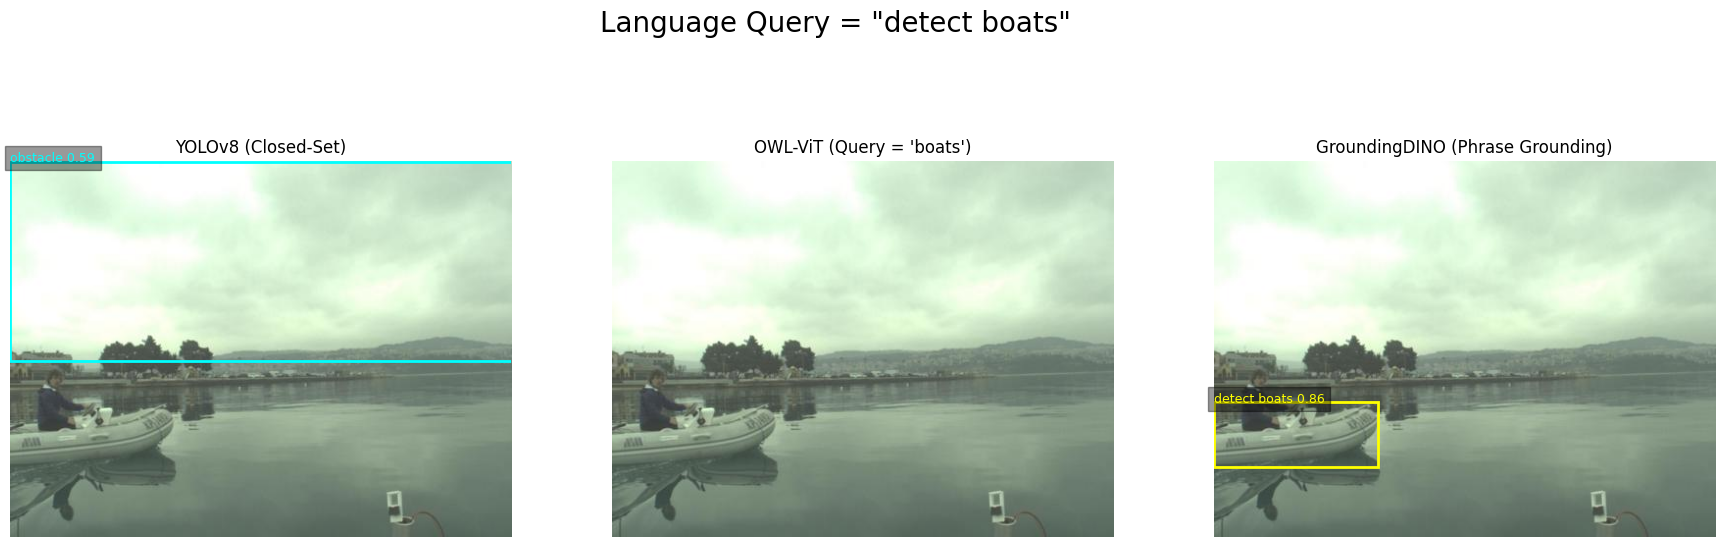

In [28]:
import random
test_img = random.choice(list(VAL_IMAGES.glob("*.jpg")))

prompt = "detect boats"
run_language_demo(test_img, prompt)

### Save Results